## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

In [129]:
# load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy as sp

import sklearn as skl
#######################
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import confusion_matrix, classification_report
from xgboost import XGBClassifier
import time, pickle
#######################
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from imblearn.over_sampling import SMOTE

In [130]:
# load in the data
train_data = pd.read_csv('./training.csv')
train_data_new = train_data
train_data_new.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


In [131]:
train_data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84534 entries, 0 to 84533
Data columns (total 10 columns):
ID           84534 non-null int64
Promotion    84534 non-null object
purchase     84534 non-null int64
V1           84534 non-null int64
V2           84534 non-null float64
V3           84534 non-null float64
V4           84534 non-null int64
V5           84534 non-null int64
V6           84534 non-null int64
V7           84534 non-null int64
dtypes: float64(2), int64(7), object(1)
memory usage: 6.4+ MB


In [132]:
train_data_new.describe()

,ID,purchase,V1,V2,V3,V4,V5,V6,V7
count,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000
mean,62970.972413,0.012303,1.500662,29.973600,0.000190,1.679608,2.327643,2.502898,1.701694
std,36418.440539,0.110234,0.868234,5.010626,1.000485,0.466630,0.841167,1.117349,0.457517
min,1.000000,0.000000,0.000000,7.104007,-1.684550,1.000000,1.000000,1.000000,1.000000
25%,31467.250000,0.000000,1.000000,26.591501,-0.905350,1.000000,2.000000,2.000000,1.000000
50%,62827.500000,0.000000,2.000000,29.979744,-0.039572,2.000000,2.000000,3.000000,2.000000
75%,94438.750000,0.000000,2.000000,33.344593,0.826206,2.000000,3.000000,4.000000,2.000000
max,126184.000000,1.000000,3.000000,50.375913,1.691984,2.000000,4.000000,4.000000,2.000000


In [133]:
train_data_new.groupby(['Promotion', 'purchase']).count()

ID     V1     V2     V3     V4     V5     V6     V7
Promotion purchase                                                        
No        0         41851  41851  41851  41851  41851  41851  41851  41851
          1           319    319    319    319    319    319    319    319
Yes       0         41643  41643  41643  41643  41643  41643  41643  41643
          1           721    721    721    721    721    721    721    721

In [134]:
new_promotion_col = pd.get_dummies(train_data_new['Promotion'], dummy_na=False, drop_first=True)

In [135]:
new_promotion_col.head()

,Yes
0,0
1,0
2,0
3,0
4,1


In [136]:
train_data_new = pd.concat([train_data_new, new_promotion_col], axis=1)

In [137]:
train_data_new.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7,Yes
0,1,No,0,2,30.443518,-1.165083,1,1,3,2,0
1,3,No,0,3,32.159350,-0.645617,2,3,2,2,0
2,4,No,0,2,30.431659,0.133583,1,1,4,2,0
3,5,No,0,0,26.588914,-0.212728,2,1,4,2,0
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2,1


In [138]:
train_data_new.drop(columns='Promotion', inplace=True)

In [139]:
train_data_new.head()

,ID,purchase,V1,V2,V3,V4,V5,V6,V7,Yes
0,1,0,2,30.443518,-1.165083,1,1,3,2,0
1,3,0,3,32.159350,-0.645617,2,3,2,2,0
2,4,0,2,30.431659,0.133583,1,1,4,2,0
3,5,0,0,26.588914,-0.212728,2,1,4,2,0
4,8,0,3,28.044332,-0.385883,1,1,2,2,1


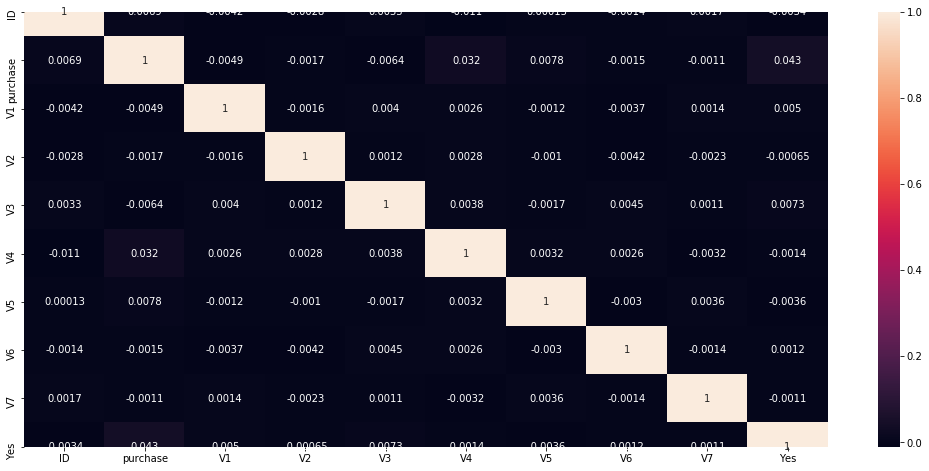

In [140]:
plt.figure(figsize=(18,8))
sns.heatmap(train_data_new.corr(), annot=True)

In [141]:
train_data_new.columns

Index(['ID', 'purchase', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'Yes'], dtype='object')

In [142]:
X = train_data_new[['Yes', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']]
#X = train_data_new[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']]
y = train_data_new['purchase']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)


In [143]:
logmodel = LogisticRegression()

In [144]:
logmodel.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [145]:
prediction = logmodel.predict(X_test)

In [146]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     33387
           1       0.00      0.00      0.00       427

    accuracy                           0.99     33814
   macro avg       0.49      0.50      0.50     33814
weighted avg       0.97      0.99      0.98     33814



/Users/akbaralishaikh/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [147]:
print(confusion_matrix(y_test,prediction))

[[33387     0]
 [  427     0]]


# Due to imbalanced data, analysis looks bias.

<b> Training dataset need to be balanced, approach used is  Synthetic Minority Over-sampling Technique (SMOTE)</b>

#########################################

In [170]:
train_data_1 = train_data.copy()

In [171]:
train_data_1["response"] = (train_data_1["Promotion"] == "Yes") & (train_data_1["purchase"] == 1)

In [172]:
features = ["V"+str(x) for x in range(1,8)]
features

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']

In [173]:
X = train_data_1[features]

In [174]:
Y = train_data_1["response"]

In [175]:
Y.value_counts()

False    83813
True       721
Name: response, dtype: int64

In [176]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=101)

In [177]:
sm = SMOTE(random_state=101, ratio=1.0)

In [178]:
X_smote_train, y_smote_train = sm.fit_resample(X_train, y_train)

/Users/akbaralishaikh/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [179]:
X_smote_train = pd.DataFrame(X_smote_train, columns=features)

In [180]:
X_smote_train.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7'], dtype='object')

In [181]:
Y_smote_train = pd.Series(y_smote_train)

In [182]:
def f1_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    err = 1-f1_score(y_true, np.round(y_pred))
    return 'f1_err', err

cv = GridSearchCV(estimator=XGBClassifier(), param_grid={
        "max_depth": range(5,8,1),
        "min_child_weight": [5, 10, 20, 50],
        "gamma": [0, 0.1, 0.2],
        "random_state": [42],
        "n_estimators": [1000]
        },         
        scoring="f1", cv=3)


start_time = time.time()
fit_params= {
            "eval_set": [(X_test, y_test)],
            "eval_metric": f1_eval,
            "early_stopping_rounds":20,
            "verbose": 0
        }
cv.fit(X_smote_train, Y_smote_train, **fit_params)
elapsed_time = (time.time() - start_time) / 60
print('Elapsed computation time: {:.3f} mins'.format(elapsed_time))

Elapsed computation time: 8.622 mins


In [183]:
cv.best_params_

{'gamma': 0.2,
 'max_depth': 6,
 'min_child_weight': 10,
 'n_estimators': 1000,
 'random_state': 42}

In [184]:
xgb = XGBClassifier(n_estimators=1000)
best_params_xgb = cv.best_params_
xgb.set_params(**best_params_xgb)
xgb.fit(X=X_smote_train, y=Y_smote_train.values.ravel(), eval_set=[(X_test, y_test)], 
        eval_metric=f1_eval, early_stopping_rounds=10, verbose=10)

[0]	validation_0-error:0.347992	validation_0-f1_err:0.969515
Multiple eval metrics have been passed: 'validation_0-f1_err' will be used for early stopping.

Will train until validation_0-f1_err hasn't improved in 10 rounds.
[10]	validation_0-error:0.152836	validation_0-f1_err:0.96779
[20]	validation_0-error:0.109718	validation_0-f1_err:0.968163
Stopping. Best iteration:
[11]	validation_0-error:0.152718	validation_0-f1_err:0.967766



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.2,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=10, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [185]:
optimal_n_estimators = xgb.best_ntree_limit

In [186]:
X_balanced, Y_balanced = sm.fit_sample(X,Y)
X_balanced = pd.DataFrame(X_balanced, columns=features)
Y_balanced = pd.Series(Y_balanced)

/Users/akbaralishaikh/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [187]:
xgb = XGBClassifier(max_depth=best_params_xgb["max_depth"],
                    gamma=best_params_xgb["gamma"],
                    min_child_weight=best_params_xgb["min_child_weight"],
                    n_estimators=optimal_n_estimators,
                    random_state=42)
xgb.fit(X_balanced, Y_balanced)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.2,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=10, missing=None, n_estimators=12, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [188]:
pickle.dump(xgb, open('xgb_best_approach_1.pkl', 'wb'))

In [189]:
model = pickle.load(open("xgb_best_approach_1.pkl", 'rb'))

In [190]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    
    test = df
    
    preds = model.predict(test)
    promotion = []
    for pred in preds:
        if pred:
            promotion.append('Yes')
        else:
            promotion.append('No')
    promotion = np.array(promotion)
    
    
    return promotion

In [191]:
test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0210.

Your nir with this strategy is 309.50.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.020950072984425267, 309.5)